<a href="https://colab.research.google.com/github/dvoils/neural-network-experiments/blob/main/ion_channels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ion Channels

The classic **Hodgkin-Huxley (HH) model** describes spike generation in the squid giant axon using **sodium** and **potassium** channels. In that model:

* A brief influx of **sodium ions** triggers the action potential (spike).
* An efflux of **potassium ions** follows, repolarizing the membrane.

This basic mechanism (fast Na$^+$ influx followed by K$^+$ efflux) underlies spike generation across many organisms.

However, **cortical neurons** in vertebrates have **many more types of ion channels**, leading to more diverse and complex electrophysiological behavior.

## Membrane Potential

The following describes the dynamics of membrane potential $u(t)$:

$$
C \frac{d}{dt} u(t) = I_{syn}(t) + \sum_k I_k(t)
$$

where:

* $C$ is membrane capacitance.
* $I_{syn}(t)$ is the synaptic input current (current from synapses).
* $I_k(t)$ are currents from various ion channels.

In essence, this equation says: the rate of change of membrane voltage depends on the net current flowing into the neuron.

## Ionic Current

The ionic current through a specific channel $k$ is:

$$
I_k = \bar{g}_k m^{p_k} h^{q_k} (u - E_k)
$$

where:

* $\bar{g}_k$ is the maximum conductance of the channel.
* $m$ and $h$ are gating variables representing activation and inactivation.
* $p_k$ and $q_k$ are exponents describing how the gating variables contribute to channel conductance (typically from empirical fits).
* $E_k$ is the reversal potential (where there is no net current flow).

In the original HH model, for potassium, typically $p_k = 4$ and $q_k = 0$, meaning inactivation ($h$) is omitted.

While the HH model is a solid foundation (with two channel types), real neurons have **many different channels**.



# Figures — Gating Variables and Time Constants of Ion Currents

## Overview

This figure compares the voltage-dependent activation/inactivation properties of three ion currents commonly found in neurons:

| Panel | Current Type              | Symbol           | Description                                  |
| ----- | ------------------------- | ---------------- | -------------------------------------------- |
| A     | Persistent Sodium Current | $I_{\text{NaP}}$ | Non-inactivating sodium current              |
| B     | Transient Sodium Current  | $I_{\text{Na}}$  | Classic fast spiking Na$^+$ current          |
| C     | T-type Calcium Current    | $I_T$            | Low-threshold, transient Ca$^{{2+}}$ current |

Each row contains two subplots:

* **Left:** Steady-state gating variables $m_\infty(u)$ and $h_\infty(u)$
* **Right:** Corresponding time constants $\tau_m(u)$ and $\tau_h(u)$

## Gating Variable Definitions

The gating variables follow standard Hodgkin-Huxley formulations:

* **Steady-state value:**

  $$
  x_\infty(u) = \frac{\alpha_x(u)}{\alpha_x(u) + \beta_x(u)}
  $$

* **Time constant:**

  $$
  \tau_x(u) = \frac{1}{\alpha_x(u) + \beta_x(u)}
  $$

> These apply to both activation ($m$) and inactivation ($h$) gates.

## Physiological Implications

| Current          | Key Properties                                                                                     |
| ---------------- | -------------------------------------------------------------------------------------------------- |
| $I_{\text{NaP}}$ | Persistent activation, **no inactivation**. Enhances excitability during sustained depolarization. |
| $I_{\text{Na}}$  | Fast activation + slower inactivation. Responsible for the **action potential upstroke**.          |
| $I_T$            | Activates at more **negative (low) voltages**, enables **bursting** or **rebound spikes**.         |

## Figure Layout Summary

| Panel | Left Plot                    | Right Plot (Y-axis = ms)            |
| ----- | ---------------------------- | ----------------------------------- |
| A     | $m_\infty(u)$                | $\tau_m(u)$                         |
| B     | $m_\infty(u)$, $h_\infty(u)$ | $\tau_m(u)$, $0.1 \times \tau_h(u)$ |
| C     | $m_\infty(u)$, $h_\infty(u)$ | $\tau_m(u)$, $0.1 \times \tau_h(u)$ |


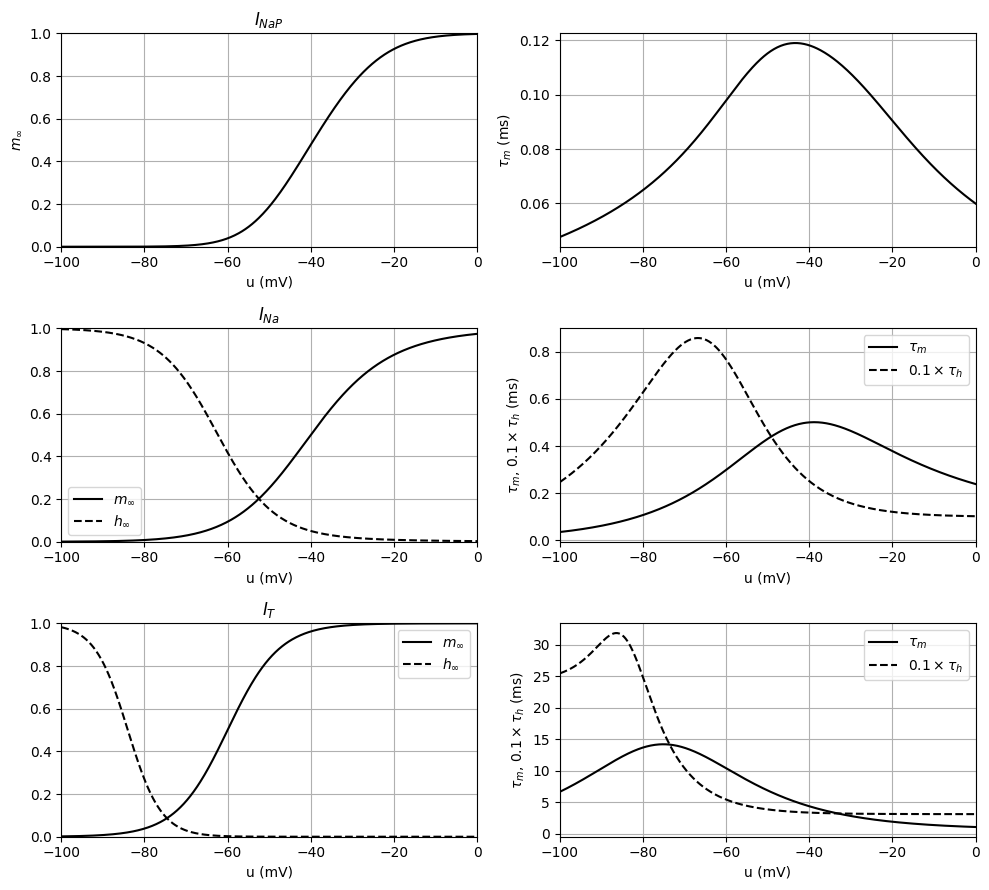

In [4]:
import numpy as np
import matplotlib.pyplot as plt

u = np.linspace(-100, 0, 500)  # mV

# --------------------------------------------------------------------
# A. Persistent Na+ current (INaP): activation only

def alpha_m_NaP(v):  # unit: 1/ms
    return 0.32 * (v + 52) / (1 - np.exp(-(v + 52) / 4))  # classic form

def beta_m_NaP(v):
    return 0.28 * (v + 25) / (np.exp((v + 25) / 5) - 1)

def m_inf_NaP(v):
    return alpha_m_NaP(v) / (alpha_m_NaP(v) + beta_m_NaP(v))

def tau_m_NaP(v):
    return 1 / (alpha_m_NaP(v) + beta_m_NaP(v))

# --------------------------------------------------------------------
# B. Transient Na+ current (INa): activation & inactivation

def alpha_m_Na(v):
    return 0.1 * (v + 40) / (1 - np.exp(-(v + 40) / 10))

def beta_m_Na(v):
    return 4.0 * np.exp(-(v + 65) / 18)

def alpha_h_Na(v):
    return 0.07 * np.exp(-(v + 65) / 20)

def beta_h_Na(v):
    return 1 / (1 + np.exp(-(v + 35) / 10))

def m_inf_Na(v):
    return alpha_m_Na(v) / (alpha_m_Na(v) + beta_m_Na(v))

def h_inf_Na(v):
    return alpha_h_Na(v) / (alpha_h_Na(v) + beta_h_Na(v))

def tau_m_Na(v):
    return 1 / (alpha_m_Na(v) + beta_m_Na(v))

def tau_h_Na(v):
    return 1 / (alpha_h_Na(v) + beta_h_Na(v))

# --------------------------------------------------------------------
# C. T-type Ca2+ current (IT)

def m_inf_T(v):
    return 1 / (1 + np.exp(-(v + 60) / 6.2))

def h_inf_T(v):
    return 1 / (1 + np.exp((v + 84) / 4))

def tau_m_T(v):
    return 1 / (np.exp(-(v + 131) / 16.7) + np.exp((v + 15.8) / 18.2)) + 0.612

def tau_h_T(v):
    return 30.8 + (211.4 + np.exp((v + 113.2) / 5)) / (1 + np.exp((v + 84) / 3.2))

# --------------------------------------------------------------------
# Plotting

fig, axs = plt.subplots(3, 2, figsize=(10, 9))
axs = axs.flatten()

# A. INaP
axs[0].plot(u, m_inf_NaP(u), label=r'$m_\infty$', color='black')
axs[0].set_title(r'$I_{NaP}$')
axs[0].set_ylabel(r'$m_\infty$')
axs[0].set_xlim(-100, 0)
axs[0].set_ylim(0, 1)

axs[1].plot(u, tau_m_NaP(u), label=r'$\tau_m$', color='black')
axs[1].set_ylabel(r'$\tau_m$ (ms)')
axs[1].set_xlim(-100, 0)

# B. INa
axs[2].plot(u, m_inf_Na(u), label=r'$m_\infty$', color='black')
axs[2].plot(u, h_inf_Na(u), label=r'$h_\infty$', linestyle='dashed', color='black')
axs[2].set_title(r'$I_{Na}$')
axs[2].legend()
axs[2].set_xlim(-100, 0)
axs[2].set_ylim(0, 1)

# B. INa (time constants with scaled tau_h)
axs[3].plot(u, tau_m_Na(u), label=r'$\tau_m$', color='black')
axs[3].plot(u, 0.1 * tau_h_Na(u), label=r'$0.1 \times \tau_h$', linestyle='dashed', color='black')
axs[3].legend()
axs[3].set_ylabel(r'$\tau_m$, $0.1 \times \tau_h$ (ms)')
axs[3].set_xlabel(r'$u$ (mV)')
axs[3].set_xlim(-100, 0)

# C. IT
axs[4].plot(u, m_inf_T(u), label=r'$m_\infty$', color='black')
axs[4].plot(u, h_inf_T(u), label=r'$h_\infty$', linestyle='dashed', color='black')
axs[4].set_title(r'$I_T$')
axs[4].legend()
axs[4].set_xlim(-100, 0)
axs[4].set_ylim(0, 1)

# C. IT (time constants with scaled tau_h)
axs[5].plot(u, tau_m_T(u), label=r'$\tau_m$', color='black')
axs[5].plot(u, 0.1 * tau_h_T(u), label=r'$0.1 \times \tau_h$', linestyle='dashed', color='black')
axs[5].set_ylabel(r'$\tau_m$, $0.1 \times \tau_h$ (ms)')
axs[5].set_xlabel(r'$u$ (mV)')
axs[5].legend()
axs[5].set_xlim(-100, 0)

# Format
for ax in axs:
    ax.set_xlabel('u (mV)')
    ax.grid(True)

plt.tight_layout()
plt.show()
